In [57]:
import argparse
import sys,os
sys.path.append('/disk/bifrost/yuanze/software/GalfitS-v0.9/src')
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["GS_DATA_PATH"] = "/disk/bifrost/yuanze/software"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from galfits import gsutils,sed_interp
from astropy.stats import sigma_clipped_stats
from astropy.visualization.mpl_normalize import simple_norm
from astropy.table import Table, Column
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import time
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM,z_at_value
from astropy.io import ascii
from importlib import reload
reload(gsutils)
reload(sed_interp)

<module 'galfits.sed_interp' from '/disk/bifrost/yuanze/software/GalfitS-v0.9/src/galfits/sed_interp.py'>

In [7]:
Tm=sed_interp.TableModel("/disk/bifrost/yuanze/software/templates/my_sed_table.npz",["t","p","q","oa","R","i"],"nu")

In [257]:
field="Q1549"
sourcename="MD10"
config_file_path = "/disk/bifrost/yuanze/KBSS/"+field+"/"+sourcename+"/GalfitS/{}.lyric".format(sourcename)
workplace = "/disk/bifrost/yuanze/KBSS/"+field+"/"+sourcename+"/GalfitS"
#readpar="/disk/bifrost/yuanze/KBSS/Q1549/BX101/GalfitS/link2.params"

parser = argparse.ArgumentParser(description="Run galfitS")
parser.add_argument("--config", type=str, default=config_file_path, help="config file of galfitS")
parser.add_argument("--workplace", type=str, default=workplace, help="filepath to store galfitS outputs")
parser.add_argument("--notfit", action='store_true', help="not fit, only generate parameter file")
parser.add_argument("--fit_method", type=str, default="optimizer", help="chisq, flowmc, dynesty, optimizer, ES")
parser.add_argument("--multistart", action='store_true', help="use multistarting points for optimizer fitting")
parser.add_argument("--nstart", type=int, default=10, help="num of starting points for optimizer fitting")
parser.add_argument("--num_steps", type=int, default=3000, help="num_steps for optimizer fitting")
parser.add_argument("--learning_rate", type=float, default=0.0008, help="learning_rate for optimizer fitting")
parser.add_argument("--baysian", action='store_true', help="using Baysian priors for optimizer fitting")
parser.add_argument("--cal_sigma", action='store_true', help="calculate hessian_sigma for optimizer fitting")
parser.add_argument("--chimethod", type=str, default="scipy", help="method for chisq fitting")
parser.add_argument("--scimethod", type=str, default="SLSQP", help="method for scipy fitting")
parser.add_argument("--constrain", action='store_true', help="constrain for chisq fitting")
parser.add_argument("--nchains", type=int, default=30, help="nchains for flowmc")
parser.add_argument("--rstep", type=float, default=0.1, help="parameter step for flowmc")
parser.add_argument("--nlocalsteps", type=int, default=3000, help="nlocalsteps for flowmc")
parser.add_argument("--nlooptraining", type=int, default=20, help="nlooptraining for flowmc")
parser.add_argument("--nloopproduction", type=int, default=10, help="nloopproduction for flowmc")
parser.add_argument("--sampler", type=str, default="GRW", help="sampler for flowmc")
parser.add_argument("--nlive", type=int, default=80, help="numbe of live point for dynesty")
parser.add_argument("--nvectorize", action='store_true', help="not vectorize the model calculation")
parser.add_argument("--maxiters", type=int, default=100000, help="maxiters for dynesty")
parser.add_argument("--dlogz", type=float, default=0.02, help="dlogz for dynesty")
parser.add_argument("--sample_method", type=str, default="rwalk", help="sample_method for dynesty")
parser.add_argument("--dynamic", action='store_true', help="dynamic for dynesty")
parser.add_argument("--maxbatch", type=int, default=10, help="maxbatch for dynesty")
parser.add_argument("--parconstrain", type=str, default="default", help="filepath to store parameter constrain")
parser.add_argument("--readpar", type=str, default="default", help="filepath to read parameter")
parser.add_argument("--readsummary", type=str, default="default", help="filepath to read summary file")
parser.add_argument("--savefull_results", action='store_true', help="save full results or not")
parser.add_argument("--weight_spec", type=float, default=1.0, help="weight of spectrum in fitting")
parser.add_argument("--num_generations", type=int, default=15000, help="num_generations for ES")
parser.add_argument("--popsize", type=int, default=30, help="popsize for ES")
parser.add_argument("--priorpath", type=str, default=workplace+"/prior.txt", help="path to the astrophysical prior file")
parser.add_argument("--fixagnlinepro", action='store_true', help="fix agn line profile or not")
parser.add_argument("--ndisagn", action='store_true', help="display agn or not in the image")
parser.add_argument("--saveimgs", action='store_true', help="save images or not")
args = parser.parse_known_args()[0]

##================================== Input =============================##
#args.agnconstrain=True
args.saveimgs=True
args.multistart=True
##======================================================================##

#print (args)
config_file_path = args.config
workplace = args.workplace
if not os.path.exists(config_file_path):
        raise ValueError("config file path not found!")
if not os.path.exists(workplace):
        os.mkdir(workplace)
        print ("workplace path not found! create it!")
Myfitter,targ,fs = gsutils.read_config_file(config_file_path,workplace,priorpath=args.priorpath,fixagnlinepro = args.fixagnlinepro,vectorize = not args.nvectorize)
if args.parconstrain != "default":
        f = open(args.parconstrain,'r')
        fs = f.read()
exec(fs)


mips_24um is a photometric point
conversion factor is  1.0
mips_24um band image unit to counts rate is  2.0650545e-20
mask image not found, use the zero mask image
mips_24um std 0.0
mosfire_H is a photometric point
conversion factor is  1.0
mosfire_H band image unit to counts rate is  2.0650545e-20
mask image not found, use the zero mask image
mosfire_H std 0.0
Un_lris is a photometric point
conversion factor is  1.0
Un_lris band image unit to counts rate is  2.0650545e-20
mask image not found, use the zero mask image
Un_lris std 0.0
G_lris is a photometric point
conversion factor is  1.0
G_lris band image unit to counts rate is  2.0650545e-20
mask image not found, use the zero mask image
G_lris std 0.0
ch4 is a photometric point
conversion factor is  1.0
ch4 band image unit to counts rate is  2.0650545e-20
mask image not found, use the zero mask image
ch4 std 0.0
INFO: using the unit cR passed to the FITS reader instead of the unit ELECTRONS/S in the FITS file. [astropy.nddata.ccddata

conversion factor is  4.0688115e+18
wfc3_f475w band image unit to counts rate is  0.08402317
wfc3_f475w std 0.0008851572
Rs_lris is a photometric point
conversion factor is  1.0
Rs_lris band image unit to counts rate is  2.0650545e-20
mask image not found, use the zero mask image
Rs_lris std 0.0
ch2 is a photometric point
conversion factor is  1.0
ch2 band image unit to counts rate is  2.0650545e-20
mask image not found, use the zero mask image
ch2 std 0.0
INFO: using the unit cR passed to the FITS reader instead of the unit ELECTRONS/S in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


conversion factor is  1.2823033e+19
acs_f606w band image unit to counts rate is  0.26480263
acs_f606w std 0.0058194557
INFO: using the unit cR passed to the FITS reader instead of the unit ELECTRONS/S in the FITS file. [astropy.nddata.ccddata]


conversion factor is  5.1879053e+19
wfc3_f160w band image unit to counts rate is  1.0713307
wfc3_f160w std 0.004760464
mosfire_J is a photometric point
conversion factor is  1.0
mosfire_J band image unit to counts rate is  2.0650545e-20
mask image not found, use the zero mask image
mosfire_J std 0.0
mosfire_Ks is a photometric point
conversion factor is  1.0
mosfire_Ks band image unit to counts rate is  2.0650545e-20
mask image not found, use the zero mask image
mosfire_Ks std 0.0
variable names: ['csx_mips_24um', 'csy_mips_24um', 'sky_mips_24um', 'csx_mosfire_H', 'csy_mosfire_H', 'sky_mosfire_H', 'csx_Un_lris', 'csy_Un_lris', 'sky_Un_lris', 'csx_G_lris', 'csy_G_lris', 'sky_G_lris', 'csx_ch4', 'csy_ch4', 'sky_ch4', 'csx_wfc3_f475w', 'csy_wfc3_f475w', 'sky_wfc3_f475w', 'csx_Rs_lris', 'csy_Rs_lris', 'sky_Rs_lris', 'csx_ch2', 'csy_ch2', 'sky_ch2', 'csx_acs_f606w', 'csy_acs_f606w', 'sky_acs_f606w', 'csx_wfc3_f160w', 'csy_wfc3_f160w', 'sky_wfc3_f160w', 'csx_mosfire_J', 'csy_mosfire_J', 'sky

In [258]:
if args.readpar != "default":
    ptab = Table.read(args.readpar, format='ascii')
    pkeys = Myfitter.pardict.keys()
    for loop in range(len(pkeys)):
            el = ptab['name'][loop]
            if ptab['vary'][loop] == 'False':
                    var = False
            else:
                    var = True
            if ptab['expr'][loop] == 'None':
                    Myfitter.lmParameters[el].set(value=ptab['value'][loop],vary=var,min=ptab['min'][loop],max=ptab['max'][loop],brute_step=ptab['brute_step'][loop])
            else:
                    Myfitter.lmParameters[el].set(value=ptab['value'][loop],vary=var,expr=ptab['expr'][loop],min=ptab['min'][loop],max=ptab['max'][loop],brute_step=ptab['brute_step'][loop])
    Myfitter.loose_fix_pars()
    f = open(workplace + '/{0}.params'.format(targ), 'w')
    print ('name value min max brute_step vary expr', file=f)
    for el in Myfitter.pardict:
            print('{0} {1} {2} {3} {4} {5} {6}'.format(el,Myfitter.pardict[el],Myfitter.lmParameters[el].min,Myfitter.lmParameters[el].max,Myfitter.lmParameters[el].brute_step,Myfitter.lmParameters[el].vary,Myfitter.lmParameters[el].expr), file=f)
    f.close()
    # update constraints
    fs = gsutils.generate_cons_func(Myfitter.lmParameters)
    exec(fs)
    f = open(workplace + '/{0}.constrain'.format(targ), 'w')
    print(fs, file=f)
    f.close()

if args.readsummary != "default":
    sumfile = ascii.read(args.readsummary)
    for loop in range(len(sumfile)):
            try:
                    Myfitter.lmParameters[sumfile['pname'][loop]].set(value = sumfile['best_value'][loop])
            except KeyError:
                    print ("{0} not in parameter list, skip it!".format(sumfile['pname'][loop]))
    Myfitter.loose_fix_pars()

if not args.notfit:
    # timeing
    start = time.time()
    Myfitter.Set_Update_Constraints(Update_Constraints)
    Myfitter.set_wight_spec(args.weight_spec)
    if args.fit_method == "chisq":
            fr = Myfitter.minimize(method=args.chimethod,scipymethod=args.scimethod,constrain = args.constrain)
    elif args.fit_method == "flowmc":
            fr = Myfitter.flowmc(n_chains = args.nchains, r_step = args.rstep, n_local_steps = args.nlocalsteps, n_loop_training = args.nlooptraining, n_loop_production = args.nloopproduction, sampler = args.sampler)
    elif args.fit_method == "dynesty":
            fr = Myfitter.nested_sampling(maxiters=args.maxiters, nlive=args.nlive,dlogz = args.dlogz,sample_method=args.sample_method,dynamical=args.dynamic,dynesty_kwargs={'maxbatch': args.maxbatch , 'use_stop': False,})
    elif args.fit_method == "optimizer":
            fr = Myfitter.optimizer(num_steps=args.num_steps, learning_rate=args.learning_rate, calsigma=args.cal_sigma)
    elif args.fit_method == "ES":
            fr = Myfitter.evolution_strategies(num_generations=args.num_generations, popsize=args.popsize)
    else:
            raise ValueError("fit_method not supported!")
    stop = time.time()


    if args.savefull_results:
            if args.fit_method == "chisq":
                    result = {
                    'resultDit': fr,
                    'pardict': Myfitter.pardict,
                    'varnames': Myfitter.varnames,
                    }
            else:
                    result = {
                    'resultDit': dict(fr),
                    'pardict': Myfitter.pardict,
                    'varnames': Myfitter.varnames,
                    }
            pickle.dump(result,open(workplace + '/{0}.gsresu'.format(targ),"wb"))

    # write summary file
    f = open(workplace + '/{0}.gssummary'.format(targ),'w')
    f.write('# target: {0}\n'.format(targ))
    f.write('# config file: {0}\n'.format(config_file_path))
    f.write('# fitting mode: {0}\n'.format(Myfitter.GSdata.fitMode))
    if Myfitter.GSdata.fitMode == "single image - photometry":
            f.write('### Magnitude can be found in fixed parameters.\n')
            f.write('### Magnitude error can be calculated by 2.5 times the logM error.\n')
    f.write('# fiting method: {0}\n'.format(args.fit_method))
    f.write('# chisq: {0}\n'.format(Myfitter.chisq))
    f.write('# reduced chisq: {0}\n'.format(Myfitter.chisq/Myfitter.dof))
    f.write('# fitting time: {0} mins\n'.format((stop-start)/60.))
    f.write('######################################### \n')
    if args.fit_method == "chisq":
            f.write('# method: {0}  scipymethod: {1} \n'.format(args.chimethod,args.scimethod))
            f.write('# free parameters:\n')
            f.write('pname    best_value\n')
            ncol = 2
            for loop, var in enumerate(Myfitter.varnames):
                    f.write('{0}    {1:.4f}\n'.format(var,Myfitter.theta0[loop]))
    elif args.fit_method == "ES":
            f.write('# num_generations: {0}  popsize: {1} \n'.format(args.num_generations,args.popsize))
            f.write('# free parameters:\n')
            f.write('pname    best_value \n')
            ncol = 2
            for loop, var in enumerate(Myfitter.varnames):
                    f.write('{0}    {1:.4f}\n'.format(var,fr['theta'][loop]))
    elif args.fit_method == "optimizer":
            f.write('# num_steps: {0}  learning_rate: {1} calculate_hessian: {2} \n'.format(args.num_steps,args.learning_rate,args.cal_sigma))
            f.write('# free parameters:\n')
            if args.cal_sigma:
                    f.write('pname    best_value    best_value_uncertainty\n')
                    ncol = 3
                    for loop, var in enumerate(Myfitter.varnames):
                            f.write('{0}    {1:.4f}    {2:.4f}\n'.format(var,fr['theta'][loop],fr['param_errors'][loop]))
            else:
                    f.write('pname    best_value\n')
                    ncol = 2
                    for loop, var in enumerate(Myfitter.varnames):
                            f.write('{0}    {1:.4f}\n'.format(var,fr['theta'][loop]))       
    elif args.fit_method == "flowmc":
            f.write('# nchains: {0} parastep: {1} nlocalsteps: {2} nlooptraining: {3} nloopproduction: {4} sampler: {5}\n'.format(args.nchains,args.rstep,args.nlocalsteps,args.nlooptraining,args.nloopproduction,args.sampler))
            f.write('# free parameters:\n')
            f.write('pname    50%_value    16%_value     84%_value\n')
            ncol = 4
            for loop, var in enumerate(Myfitter.varnames):
                    f.write('{0}    {1:.4f}    {2:.4f}    {3:.4f}\n'.format(var,fr['quantiles'][0][loop],fr['quantiles'][1][loop],fr['quantiles'][2][loop]))
    elif args.fit_method == "dynesty":
            f.write('# maxiters: {0} nlive: {1} dlogz: {2} sample_method: {3} dynamic: {4} maxbatch: {5}\n'.format(args.maxiters,args.nlive,args.dlogz,args.sample_method,args.dynamic,args.maxbatch))
            f.write('# free parameters:\n')
            f.write('pname    best_value    uncertainty\n')
            ncol = 3
            for loop, var in enumerate(Myfitter.varnames):
                    f.write('{0}    {1:.4f}    {2:.4f}\n'.format(var,fr['best_theta'][loop],fr['uncertainty'][loop]))
    f.write('# fixed parameters:\n')
    f.write('# pname    fixed_value\n')
    for el in Myfitter.pardict.keys():
            if not Myfitter.lmParameters[el].vary:
                    if ncol == 2:  
                            f.write('{0}    {1:.4f}\n'.format(el,np.array(Myfitter.pardict[el])))
                    elif ncol == 3:
                             f.write('{0}    {1:.4f}    nan\n'.format(el,np.array(Myfitter.pardict[el])))
                    elif ncol == 4:
                            f.write('{0}    {1:.4f}    nan    nan\n'.format(el,np.array(Myfitter.pardict[el])))
    f.write('######################################### \n')
    f.close()
    
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":6,
"legend.fancybox":True})
gsutils.standard_display(Myfitter, workplace, targ, ndisage = args.ndisagn)

Step 0, Chisq: 100027.625
Step 100, Chisq: 42329.69140625
Step 200, Chisq: 31926.1171875
Step 300, Chisq: 29241.365234375
Step 400, Chisq: 27318.2578125
Step 500, Chisq: 26492.380859375
Step 600, Chisq: 25780.90625
Step 700, Chisq: 25124.73828125
Step 800, Chisq: 24514.95703125
Step 900, Chisq: 23935.23046875
Step 1000, Chisq: 23375.630859375
Step 1100, Chisq: 22838.099609375
Step 1200, Chisq: 22330.892578125
Step 1300, Chisq: 21863.0859375
Step 1400, Chisq: 21441.9296875
Step 1500, Chisq: 21069.599609375
Step 1600, Chisq: 20744.369140625
Step 1700, Chisq: 20466.8984375
Step 1800, Chisq: 20217.140625
Step 1900, Chisq: 20013.201171875
Step 2000, Chisq: 19837.458984375
Step 2100, Chisq: 19764.97265625
Step 2200, Chisq: 19696.59375
Step 2300, Chisq: 19630.083984375
Step 2400, Chisq: 19564.0859375
Step 2500, Chisq: 19501.49609375
Step 2600, Chisq: 19437.662109375
Step 2700, Chisq: 19377.177734375
Step 2800, Chisq: 19318.283203125
Step 2900, Chisq: 19262.431640625


In [251]:
#pltwave, Sedcomp, Sedlabel, z = Myfitter.cal_model_image(ndisag                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      n=False)
galaxy = Myfitter.model_list[1]
AGN = Myfitter.model_list[0]

im = Myfitter.GSdata.get_image(2)
print(im.band)
image_atlas = Myfitter.GSdata.image_atlas_list[1]
print(image_atlas.name)



wfc3_f160w
lris


In [252]:
#tidalimg = galaxy.generate_subcomponent_image(im.band,im.PSF,'tidal')*im.phys_to_counts_rate
ny,nx=im.cut_image.shape
Gimage,apertures = galaxy.generate_mass_map((ny,nx),transpar=im.coordinates_transfer_para)
#bulgeimg = galaxy.generate_subcomponent_image(im.band,im.PSF,'tidal',nebularpar = Myfitter.pardict)*im.phys_to_counts_rate
#armimg = galaxy.generate_subcomponent_image(im.band,im.PSF,'arm',nebularpar = Myfitter.pardict)*im.phys_to_counts_rate
gimage = galaxy.generate_image(im.band,im.PSF,im.resp,noSED=False,nebularpar = Myfitter.pardict)*im.phys_to_counts_rate
pardict= Myfitter.pardict
nuim = AGN.generate_image([Myfitter.pardict['xcen_nu'],Myfitter.pardict['ycen_nu']],(ny,nx),im.band,im.PSF,resp=im.resp,transpar=im.coordinates_transfer_para,pardict=Myfitter.pardict)
nuim *= Myfitter.pardict['Ni_{0}_{1}'.format(AGN.prefix,image_atlas.name)]
nuim *= im.phys_to_counts_rate

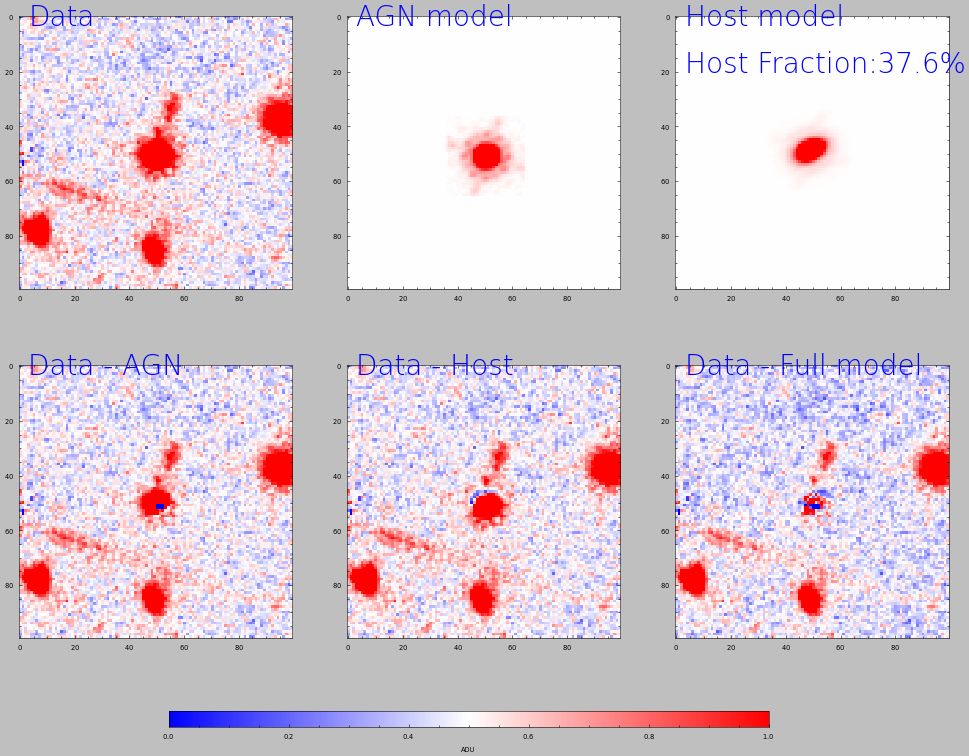

In [253]:
import jax.numpy as jnp
from matplotlib.colors import LogNorm
from matplotlib.colorbar import ColorbarBase
sky_mean, sky_median, sky_std = sigma_clipped_stats(im.cut_image, sigma=3.0, maxiters=5)
immin = -5*sky_std
immax = jnp.max(im.cut_image)
frac = 0.8
norm = simple_norm([-5*sky_std, 5*sky_std], 'linear', percent=99)
#norm= LogNorm()
cmap='bwr'
interpolation='nearest'
fig,axs=plt.subplots(2,3,figsize=(15, 10),squeeze=True)
axs=axs.ravel()
axs[0].imshow(im.cut_image-sky_median,cmap=cmap,interpolation=interpolation, norm=norm)
axs[1].imshow(nuim,cmap=cmap,interpolation=interpolation, norm=norm)
axs[2].imshow(gimage, cmap=cmap,interpolation=interpolation, norm=norm)
axs[3].imshow((im.cut_image-nuim-sky_median), cmap=cmap,interpolation=interpolation, norm=norm)
axs4=axs[4].imshow((im.cut_image-gimage-sky_median), cmap=cmap,interpolation=interpolation, norm=norm)
axs[5].imshow((im.cut_image-im.model_image-sky_median), cmap=cmap,interpolation=interpolation, norm=norm)
#axs[0].scatter(xcen,ycen)
cbax = fig.add_axes([0.25,0.0,0.5,0.02])
cbar = ColorbarBase(cbax, cmap=cmap,orientation='horizontal',label="ADU")
axs[0].text(3,3, "Data", size = 25, color = 'b', weight = "light" )
axs[1].text(3,3, "AGN model", size = 25, color = 'b', weight = "light" )
axs[2].text(3,3, "Host model", size = 25, color = 'b', weight = "light" )
axs[3].text(3,3, "Data - AGN", size = 25, color = 'b', weight = "light" )
axs[4].text(3,3, "Data - Host", size = 25, color = 'b', weight = "light" )
axs[5].text(3,3, "Data - Full model", size = 25, color = 'b', weight = "light" )
hf=np.nansum(gimage)/np.nansum(nuim)*100
axs[2].text(3,20, "Host Fraction:{:.1f}%".format(hf), size = 25, color = 'b', weight = "light" )
#print("host fraction (%):",np.nansum(gimage)/np.nansum(nuim)*100)
fig.savefig(workplace+"/decomp_{}.png".format(im.band),dpi=300)



In [225]:
import numpy as np
import astropy.units as u
from astropy.cosmology import Planck18

def age_at_redshift(z):
    """
    Age of the Universe at redshift z (Planck18).
    Returns an astropy Quantity in Gyr.
    """
    z = np.asarray(z, dtype=float)
    return Planck18.age(z)  # Quantity

def lookback_time_to_redshift(z):
    """
    Lookback time to redshift z (Planck18).
    Returns an astropy Quantity in Gyr.
    """
    z = np.asarray(z, dtype=float)
    return Planck18.lookback_time(z)  # Quantity

# Example usage
#z = 2.3
print(f"Age at z={z}:", age_at_redshift(z).to(u.Gyr))
print(f"Lookback time to z={z}:", lookback_time_to_redshift(z).to(u.Gyr))
print("Age today (z=0):", Planck18.age(0).to(u.Gyr))

NameError: name 'z' is not defined

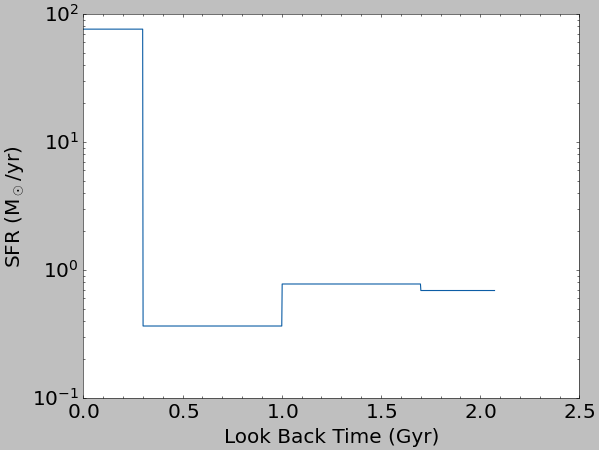

In [259]:
## Star formation history
pltwave, Sedcomp, Sedlabel, z0 = Myfitter.cal_model_image()
modelg = Myfitter.model_list[1]
times, SFHs = modelg.get_SFH()

fig = plt.figure(figsize=(8,6))
plt.plot(times, SFHs[0])
plt.xlabel('Look Back Time (Gyr)', fontsize=18)
plt.ylabel('SFR (M$_\odot$/yr)', fontsize=18)
plt.tick_params(labelsize=18)
plt.yscale('log')
plt.show()
fig.savefig(workplace+"/SFH_{}.png".format(im.band),dpi=300)


# SED plotting

In [228]:
from galfits import sed_interp as SEDs

wavegrid = jnp.logspace(3,5,1000)
waverest = wavegrid/(1+AGN.redshift)
sed=AGN.fiducial_sed(wavegrid,pardict=Myfitter.pardict)

prefix="nu"
delta=0
cm=SEDs.mycigale(waverest,delta)*pardict['agn_Av{0}'.format(prefix)]/3.1/2.5



flist, namelist = galaxy.get_component_SED(wavegrid, nebularpar = Myfitter.pardict)

sky = Myfitter.pardict['sky_{0}'.format(im.band)]
fluxphot = jnp.sum(jnp.where(im.cut_mask_image, 0., im.cut_image))/im.phys_to_counts_rate
wavephot = 5.8e4
emap = jnp.where(im.cut_mask_image, 0., im.cut_sigma_image)
errorphot = jnp.sqrt(jnp.sum(emap**2))/im.phys_to_counts_rate

surb=8.461595e-29*jnp.sum(jnp.where(im.cut_mask_image, 0., im.cut_image-sky))
MAB=-2.5*np.log10(surb)-48.6
print(surb)
print(MAB)

9.075517e-28
19.005325


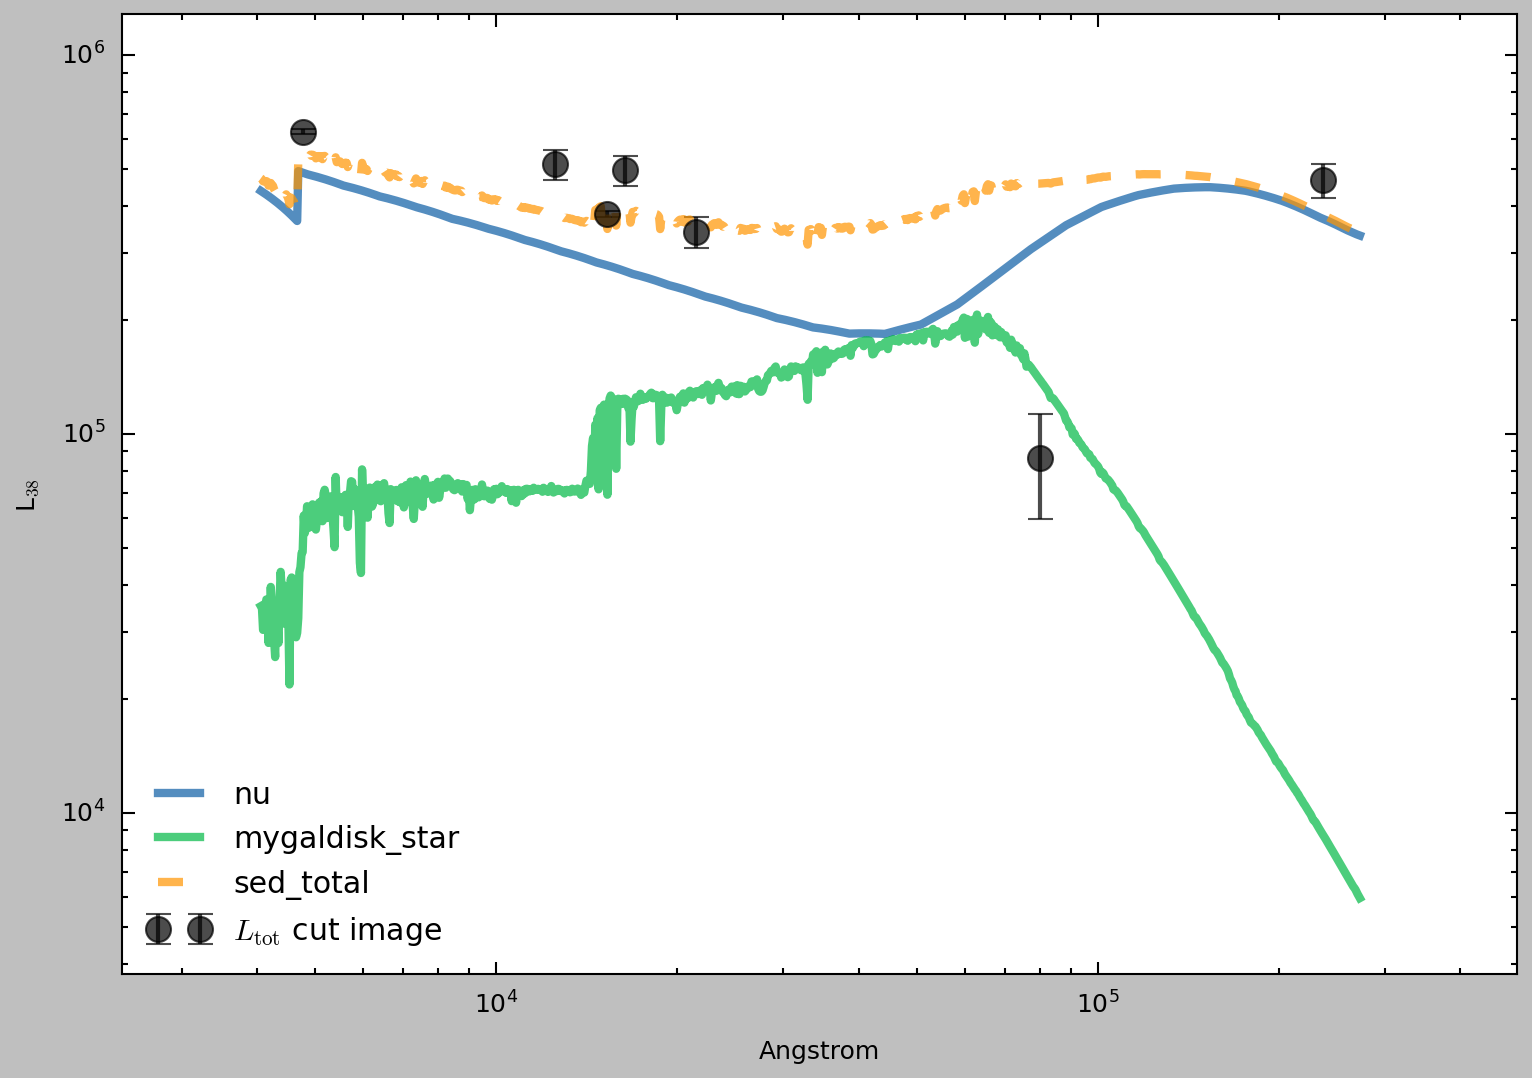

In [264]:
wrange=[0.85,1.15]
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
pltwave[0] = np.array(pltwave[0])
pltwave[1] = np.array(pltwave[1])
pltwave[3] = np.array(pltwave[3])
ax.errorbar(pltwave[0],pltwave[1]*pltwave[0],yerr=pltwave[2]*pltwave[0],fmt='o',color='k',label=r'$L_\mathrm{tot}$ cut image',alpha=0.7)
#ax.errorbar(pltwave[0],pltwave[3]*pltwave[0],fmt='o',color='r',label=r'$L_\mathrm{tot}$ model image',alpha=0.7)
waverange = [np.min(pltwave[0]),np.max(pltwave[0])]
if np.max(pltwave[0])/np.min(pltwave[0]) > 10:
    wavegrid = np.logspace(np.log10(wrange[0]*waverange[0]),np.log10(wrange[1]*waverange[1]),1000)
else:
    wavegrid = np.linspace(wrange[0]*waverange[0],wrange[1]*waverange[1],1000)
sedtot = np.zeros(len(wavegrid))
for loop in range(len(Sedcomp)):
    plt.plot(wavegrid,wavegrid*Sedcomp[loop],label=Sedlabel[loop],lw=2,alpha=0.7)
    sedtot += Sedcomp[loop]
plt.plot(wavegrid,wavegrid*sedtot,label='sed_total',lw=2,alpha=0.7,linestyle='--')  
plot_torus=False
if plot_torus:
    agnsed_rest=SEDs.cat3Dtorus(waverest,10**(pardict['{0}torus_logL'.format(prefix)]-38), pardict['{0}torus_a'.format(prefix)], pardict['{0}torus_h'.format(prefix)], pardict['{0}torus_N0'.format(prefix)], pardict['{0}torus_i'.format(prefix)])
    agnsed_rest /= 10**cm
    x,agnsed = SEDs.sed_to_obse(waverest,agnsed_rest,AGN.redshift,AGN.ebv_G)
    ax.plot(waverest,agnsed,c="r",label='Torus')
    

#plt.plot(wavegrid,sed+flist[0])
#plt.plot(wavegrid,flist[1],label='ISM')
#plt.errorbar(wavephot/(1+AGN.redshift), fluxphot,yerr=errorphot, fmt='o',color='r',alpha=0.7)
ax.legend(loc="best")
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(waverange[0]*0.5,waverange[1]*2.1)
ax.set_ylim([10000*np.min(sedtot)*0.3,10000*np.max(sedtot)*1.1])
#ax.set_ylim([1e-3,1e3])
plt.xlabel("Angstrom")
plt.ylabel(r"L$_{38}$")
#plt.text(0,0,sourcename)
fig.savefig(workplace+"/SED.png",dpi=300)

In [266]:
pltwave[1]

array([  1.9784331,   1.0781792,  24.997587 , 131.58046  ,  41.17732  ,
        30.42323  ,  15.924053 ], dtype=float32)

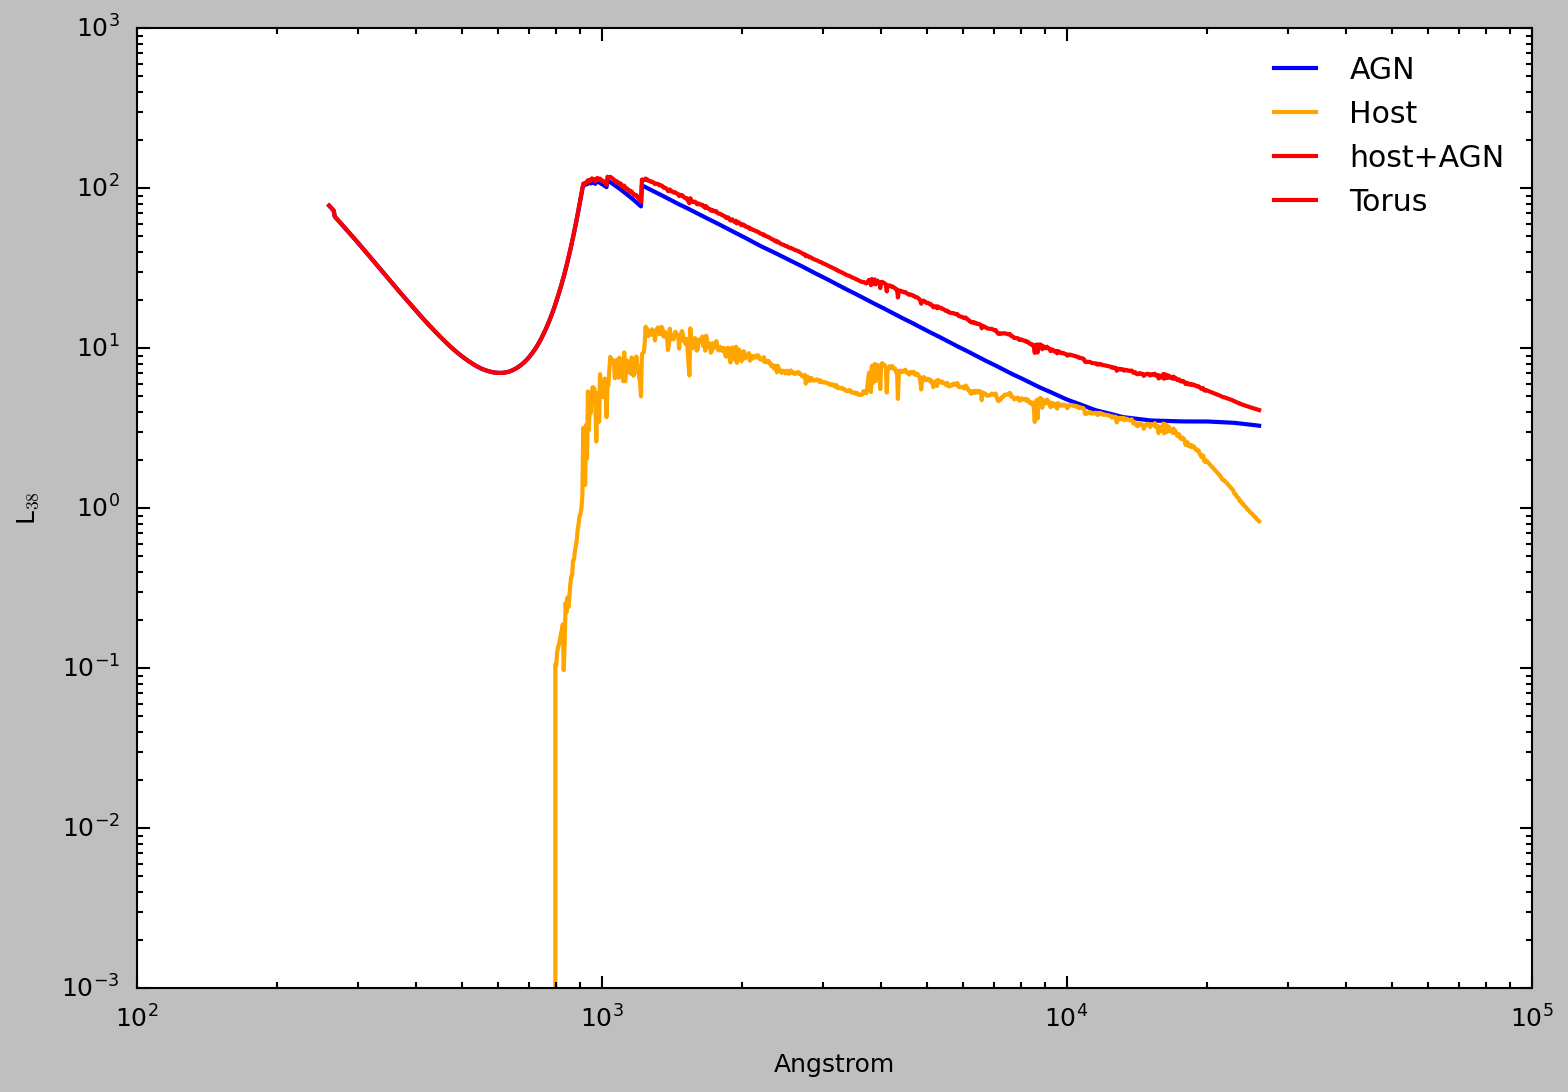

In [204]:

fig, ax = plt.subplots(figsize=(6,4),dpi=300)

ax.plot(waverest,sed,label='AGN',c="b")
ax.plot(waverest,flist[0],label='Host',c="orange")
#ax.plot(waverest,flist[1],label="ISM")
ax.plot(waverest,sed+flist[0],c="r",label='host+AGN')
plot_torus=True
if plot_torus:
    agnsed_rest=SEDs.cat3Dtorus(waverest,10**(pardict['{0}torus_logL'.format(prefix)]-38), pardict['{0}torus_a'.format(prefix)], pardict['{0}torus_h'.format(prefix)], pardict['{0}torus_N0'.format(prefix)], pardict['{0}torus_i'.format(prefix)])
    agnsed_rest /= 10**cm
    x,agnsed = SEDs.sed_to_obse(waverest,agnsed_rest,AGN.redshift,AGN.ebv_G)
    ax.plot(waverest,agnsed,c="r",label='Torus')
    
for ind,spec in enumerate(image_atlas.spectra):
    if ind !=3:
        ax.errorbar(spec[0]/(1+AGN.redshift),spec[1],yerr=spec[2],fmt="+",elinewidth=0.01,ms=0.1,alpha=0.5)
    else:
        ax.errorbar(spec[0]/(1+AGN.redshift),spec[1],yerr=spec[2],fmt="o",elinewidth=0.5,ms=1,alpha=1)
#plt.plot(wavegrid,sed+flist[0])
#plt.plot(wavegrid,flist[1],label='ISM')
#plt.errorbar(wavephot/(1+AGN.redshift), fluxphot,yerr=errorphot, fmt='o',color='r',alpha=0.7)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,1e3])
plt.xlabel("Angstrom")
plt.ylabel(r"L$_{38}$")
fig.savefig(workplace+"/SED.png",dpi=300)

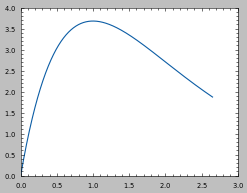

In [528]:
tau=1
sfr0=10
plt.plot(times,sfr0*times/tau**2*np.exp(-times/tau))

# IFS data generation with known AGN model and ePSF

In [157]:
#Read the coordinate transfer parameters of the IFS data
from astropy.io import fits
#from spectral_cube import SpectralCube
import images as IM
from spectral_cube import SpectralCube
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import jax.numpy as jnp
z=2.3806
cosmo = FlatLambdaCDM(H0=67.8 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.308)
d=cosmo.luminosity_distance(z)
dc=d.to(u.cm)
dis=dc.value
C_unit=1e38/(4*np.pi*dis**2)

S=np.pi*(1.8*u.arcsec)**2*1e-8

Spix=(0.3*u.arcsec)**2


factor=Spix/(u.AA/u.cm*u.cm.to(u.AA))*1e8

#factor: SB to flambda
KCWIpath='/Users/yuanze/KBSS/Q1549/BX101/kcwi_oned'
ecube='q1549-BX101_ecubes.fits'
icube='q1549-BX101_icubes_wcs.fits'




fname=KCWIpath+'/'+icube
redshift=2.3806
img = IM.image(fname,IFS=True)
inicube = SpectralCube.read(KCWIpath+'/'+icube) 
iniecube = SpectralCube.read(KCWIpath+'/'+ecube)
wavelength=inicube.spectral_axis.value
iniwcs=inicube.wcs.celestial

throughput=np.ones(len(wavelength))
throughput[(wavelength<3500) | (wavelength > 5500)]=0

psfimg=jnp.array(fits.open(KCWIpath+'/KCWI_Lya_epsf.fits')[0].data)
extpsf=psfimg[:,:,None]*throughput[None,None,:]


img.phys_to_counts_rate=1e17*C_unit


In [152]:
import profiles as Pro
import galaxy as GA
from astropy.convolution import Gaussian1DKernel,convolve
import jax

In [153]:
def generate_component_IFU(model, wavelength, posi, shape, psfimage, LSF_FWHM=1.6, GaussianLSF=True , transpar=None, pardict=None):
        # wavelength: in observed frame
        # psfimage: 3D array, the shape of empirical PSF, [y, x, wave]
        # posi: [x,y] of the position of the AGN, put in the IFU
        # LSF_FWHM: Full width at half maximum of the line spread function (bin size; 1 A=1 bin for KCWI)
        # GaussianLSF: True or False, whether the line spread function is approximated by Gaussian
        # the function 
        nx = shape[0]
        ny = shape[1]
        ns = len(wavelength)
        IFU_comp=[]
        agnsed_obs, sedcomp = model.get_component_SED(wavelength,pardict)
        nc = len(sedcomp)
        IFU =  jnp.zeros((ny,nx,ns),dtype=jnp.float32)
        #waverest = wavelength/(1.+self.redshift)
        # There was a bug. should give observed wavelength to fiducial_sed
        # The extinction already applied in fiducial_sed, no need to do it again
        #if self.Av > 0.:
        #    cm=SEDs.jccm89(waverest,self.Av,3.1)/2.5
        #    agnsed_rest /= 10**cm
        #_,agnsed_obs = SEDs.sed_to_obse(waverest,agnsed_rest,self.redshift,self.ebv_G)
        if transpar is None:
            xpix,ypix = GA.indentify_xy(posi[0],posi[1])
        else:
            xpix,ypix = GA.coordinates_transfer(posi[0],posi[1],transpar)
        # jax approach
        #def loop_body(carry, loop_vars):
        #    w_idx, agnsed_obs_value = loop_vars
        #    psf_slice = psfimage[:, :, w_idx]
        #    IFU_slice = Pro.add_PSF(xpix, ypix, nx, ny, psf_slice) * self.rnorm * agnsed_obs_value
        #    return carry, IFU_slice
        #_, IFU_slices = jax.lax.scan(loop_body, None, (jnp.arange(len(wavelength)), agnsed_obs))
        #IFU = jnp.stack(IFU_slices, axis=-1)
        # addPSF3D approach
        if GaussianLSF:
            kernel = Gaussian1DKernel(LSF_FWHM/(2*np.sqrt(2*np.log(2))))
            for loop in range(nc):
                agnsed_obs[loop]=convolve(agnsed_obs[loop][:],kernel)
        transformed_psfimage = Pro.add_PSF_3D(xpix, ypix, nx, ny, psfimage, 1.)  # using the new 3D function
        for loop in range(nc):
            IFU = transformed_psfimage * agnsed_obs[loop][:, None, None] * model.rnorm 
            IFU_comp.append(IFU.copy())
        return IFU_comp,sedcomp

In [158]:
IFU_comp,sedcomp=generate_component_IFU(AGN,wavelength,[Myfitter.pardict['agn_xnu'],Myfitter.pardict['agn_ynu']],im.cut_image.shape,extpsf
                 ,LSF_FWHM=1.6, GaussianLSF=True ,pardict=Myfitter.pardict,transpar=im.coordinates_transfer_para)

In [101]:
print(sedcomp)
print(np.shape(IFU_comp))

['Disk', 'Broad lines', 'Narrow lines', 'Torus']
(4, 2597, 32, 32)


In [8]:
import galaxy as GA
xpix,ypix = GA.coordinates_transfer(0,-0.3,img.coordinates_transfer_para)
print(xpix,ypix)

16.6 15.327999971803573


In [20]:
cutr=float(5)
ra, dec = 237.98053,19.15891
imcut, cp = img.img_cut(ra,dec,cutr,IFS=True)

In [50]:

IFU=AGN.generate_IFU(wavelength,[Myfitter.pardict['agn_xnu'],Myfitter.pardict['agn_ynu']],im.cut_image.shape,extpsf
                 ,LSF_FWHM=1.6, GaussianLSF=True ,pardict=Myfitter.pardict,transpar=im.coordinates_transfer_para)

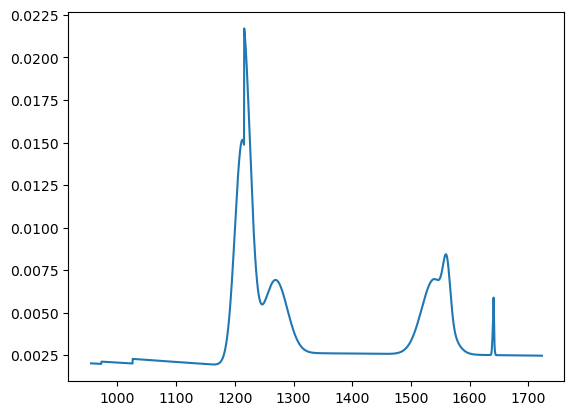

In [54]:
#print(transformed_psfimage[1230,15,15])
#print(fiducial_sed[1230])
pltwave, Sedcomp, Sedlabel, z = Myfitter.cal_model_image()
waverest = wavelength/(1.+redshift)
agnsed_rest = AGN.fiducial_sed(wavelength,Myfitter.pardict)

another_sed,sedcomp = AGN.get_component_SED(image_atlas.spectra[2][0],pardict=Myfitter.pardict)
import sed_interp as SEDs
cm=SEDs.jccm89(waverest,AGN.Av,3.1)/2.5
agnsed_rest /= 10**cm
_,agnsed_obs = SEDs.sed_to_obse(waverest,agnsed_rest,AGN.redshift,AGN.ebv_G)
plt.plot(waverest,agnsed_obs*C_unit/9e-18)


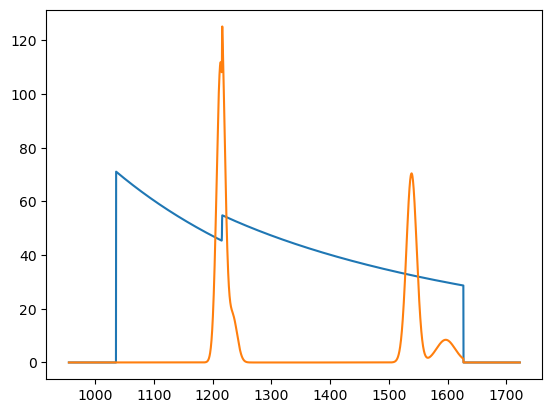

In [161]:
#plt.plot(image_atlas.spectra[0][0],image_atlas.spectra[2][1])
#plt.plot(image_atlas.spectra[0][0],image_atlas.modelspec[2])
#plt.plot(image_atlas.spectra[2][0],Sedcomp[2][0]*transformed_psfimage[500,15,15])
waverest=wavelength/(1+AGN.redshift)
plt.plot(waverest,IFU_comp[0][:,15,15])
plt.plot(waverest,IFU_comp[1][:,15,15])
#plt.yscale('log')

In [117]:
rest_wavelength=1216 # Lya line
desired_wavelength = rest_wavelength * (AGN.redshift+1)
delta=20
IFU=IFU_comp[0]+IFU_comp[1]
Lyaslicemo=np.mean(IFU[(wavelength>(desired_wavelength-delta)) & (wavelength<(desired_wavelength+delta)),:,:],axis=0)*C_unit/9e-18
Lyaslicedata=np.mean(imcut[(wavelength>(desired_wavelength-delta)) & (wavelength<(desired_wavelength+delta)),:,:],axis=0)
#transpsfslice=np.mean(transformed_psfimage[(wavelength>(1+redshift)*1210) & (wavelength<(1+redshift)*1225),:,:],axis=0)
sky_mean, sky_median, sky_std = sigma_clipped_stats(Lyaslicedata, sigma=3.0, maxiters=5)

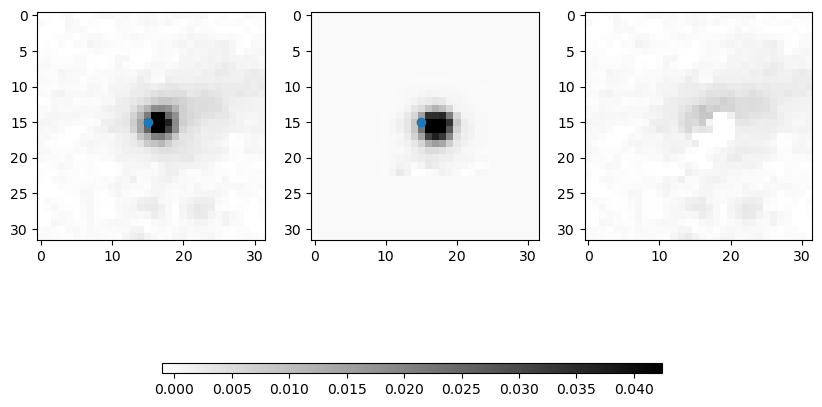

In [118]:
from matplotlib.colors import LogNorm
from matplotlib.colorbar import ColorbarBase
fig,axs=plt.subplots(1,3,figsize=(10,5))
cmap='gray_r'
norm = simple_norm(Lyaslicedata, 'linear', percent=99.)
axs[0].imshow(Lyaslicedata-sky_median,cmap=cmap,norm=norm)
axs[0].scatter(15,15)
axs[1].scatter(15,15)
axs[1].imshow(Lyaslicemo,cmap=cmap,norm=norm)
axs[2].imshow(Lyaslicedata-Lyaslicemo-sky_median,cmap=cmap,norm=norm)
#axs[1].imshow(extpsf[:,:,300],cmap=cmap,norm=norm)
cbax = fig.add_axes([0.25,0.0,0.5,0.02])
cbar = ColorbarBase(cbax, cmap=cmap,norm=norm,orientation='horizontal')

In [121]:
sedcomp

['Disk', 'Broad lines', 'Narrow lines', 'Torus']